In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction

 99% 76.0M/76.5M [00:05<00:00, 23.6MB/s]
100% 76.5M/76.5M [00:05<00:00, 15.6MB/s]


In [6]:
!unzip porto-seguro-safe-driver-prediction.zip

Archive:  porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Load Data and Do EDA

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [8]:
train = pd.read_csv('train.csv')
pd.set_option('display.max_columns', 500)
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [9]:
rows = train.shape[0]
cols = train.shape[1]
print('The train dataset contains {} rows and {} columns'.format(rows, cols))

The train dataset contains 595212 rows and 59 columns


### Data Quality Check

In [10]:
train.isnull().any().any()  # any() is applied twice to check run the isnull check across all columns

False

no missing values

In [11]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

replace -1 with NaN

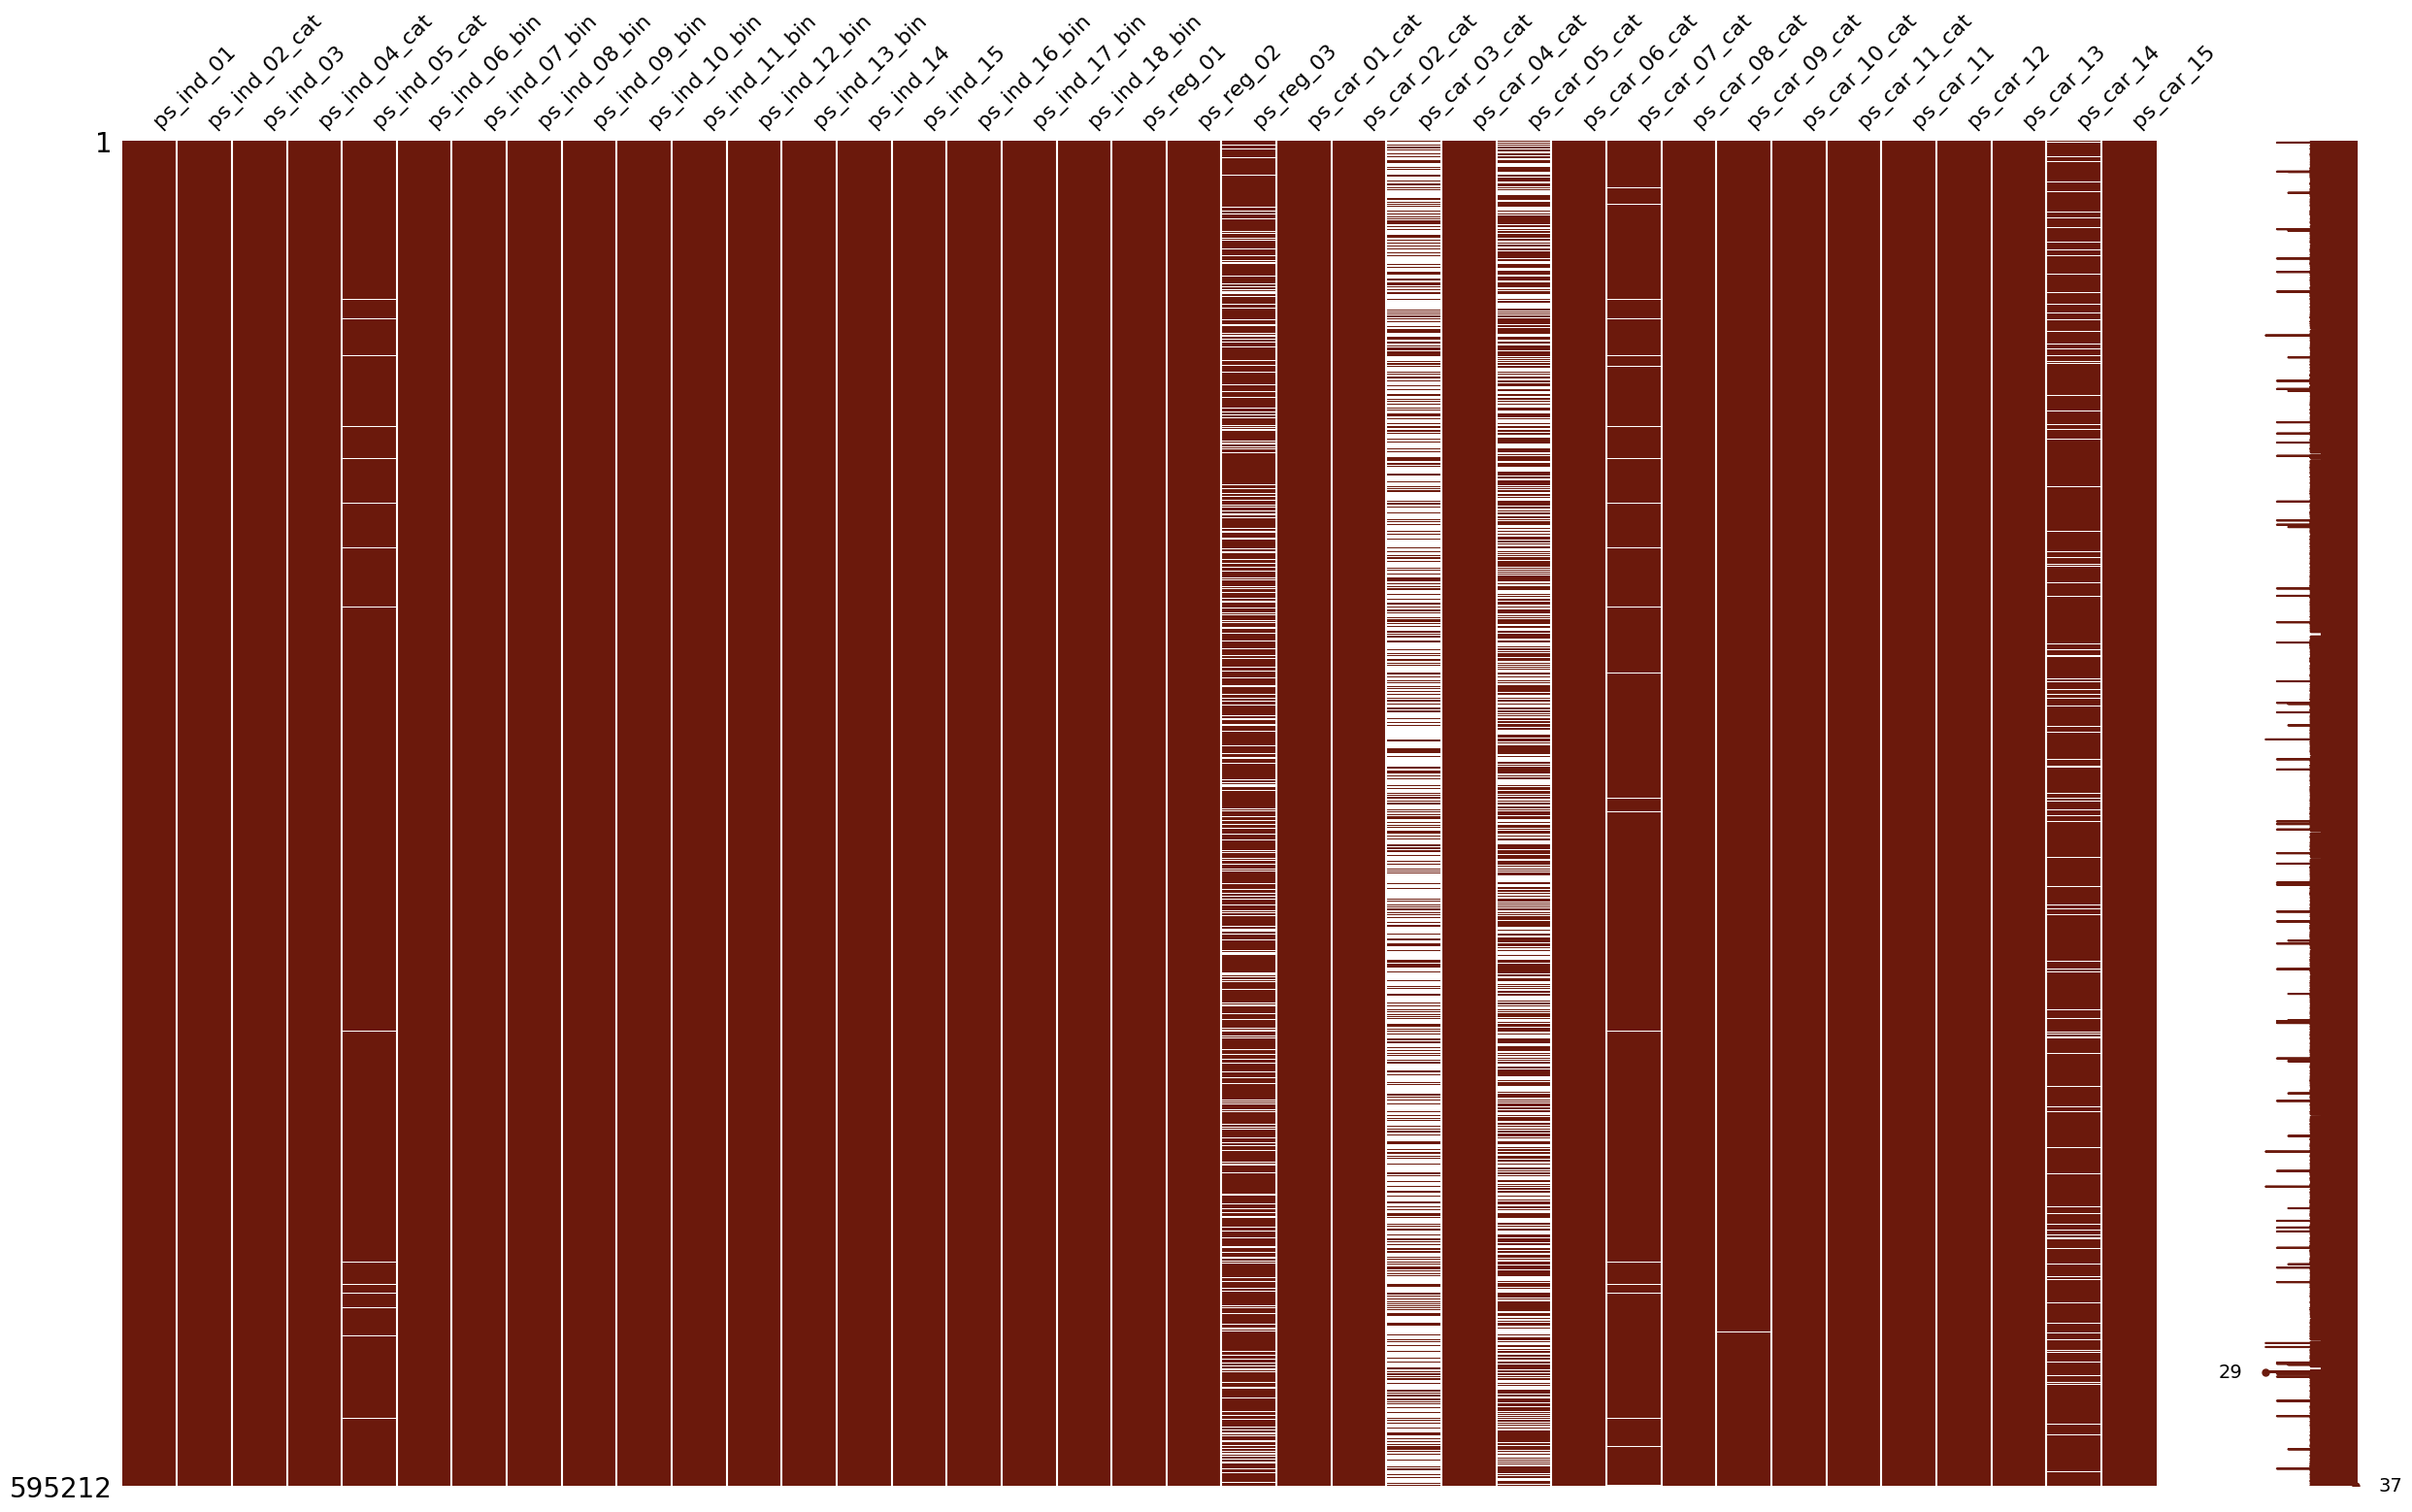

In [12]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:, 2: 39], figsize=(30, 18), color=(0.42, 0.1, 0.05))
plt.show()

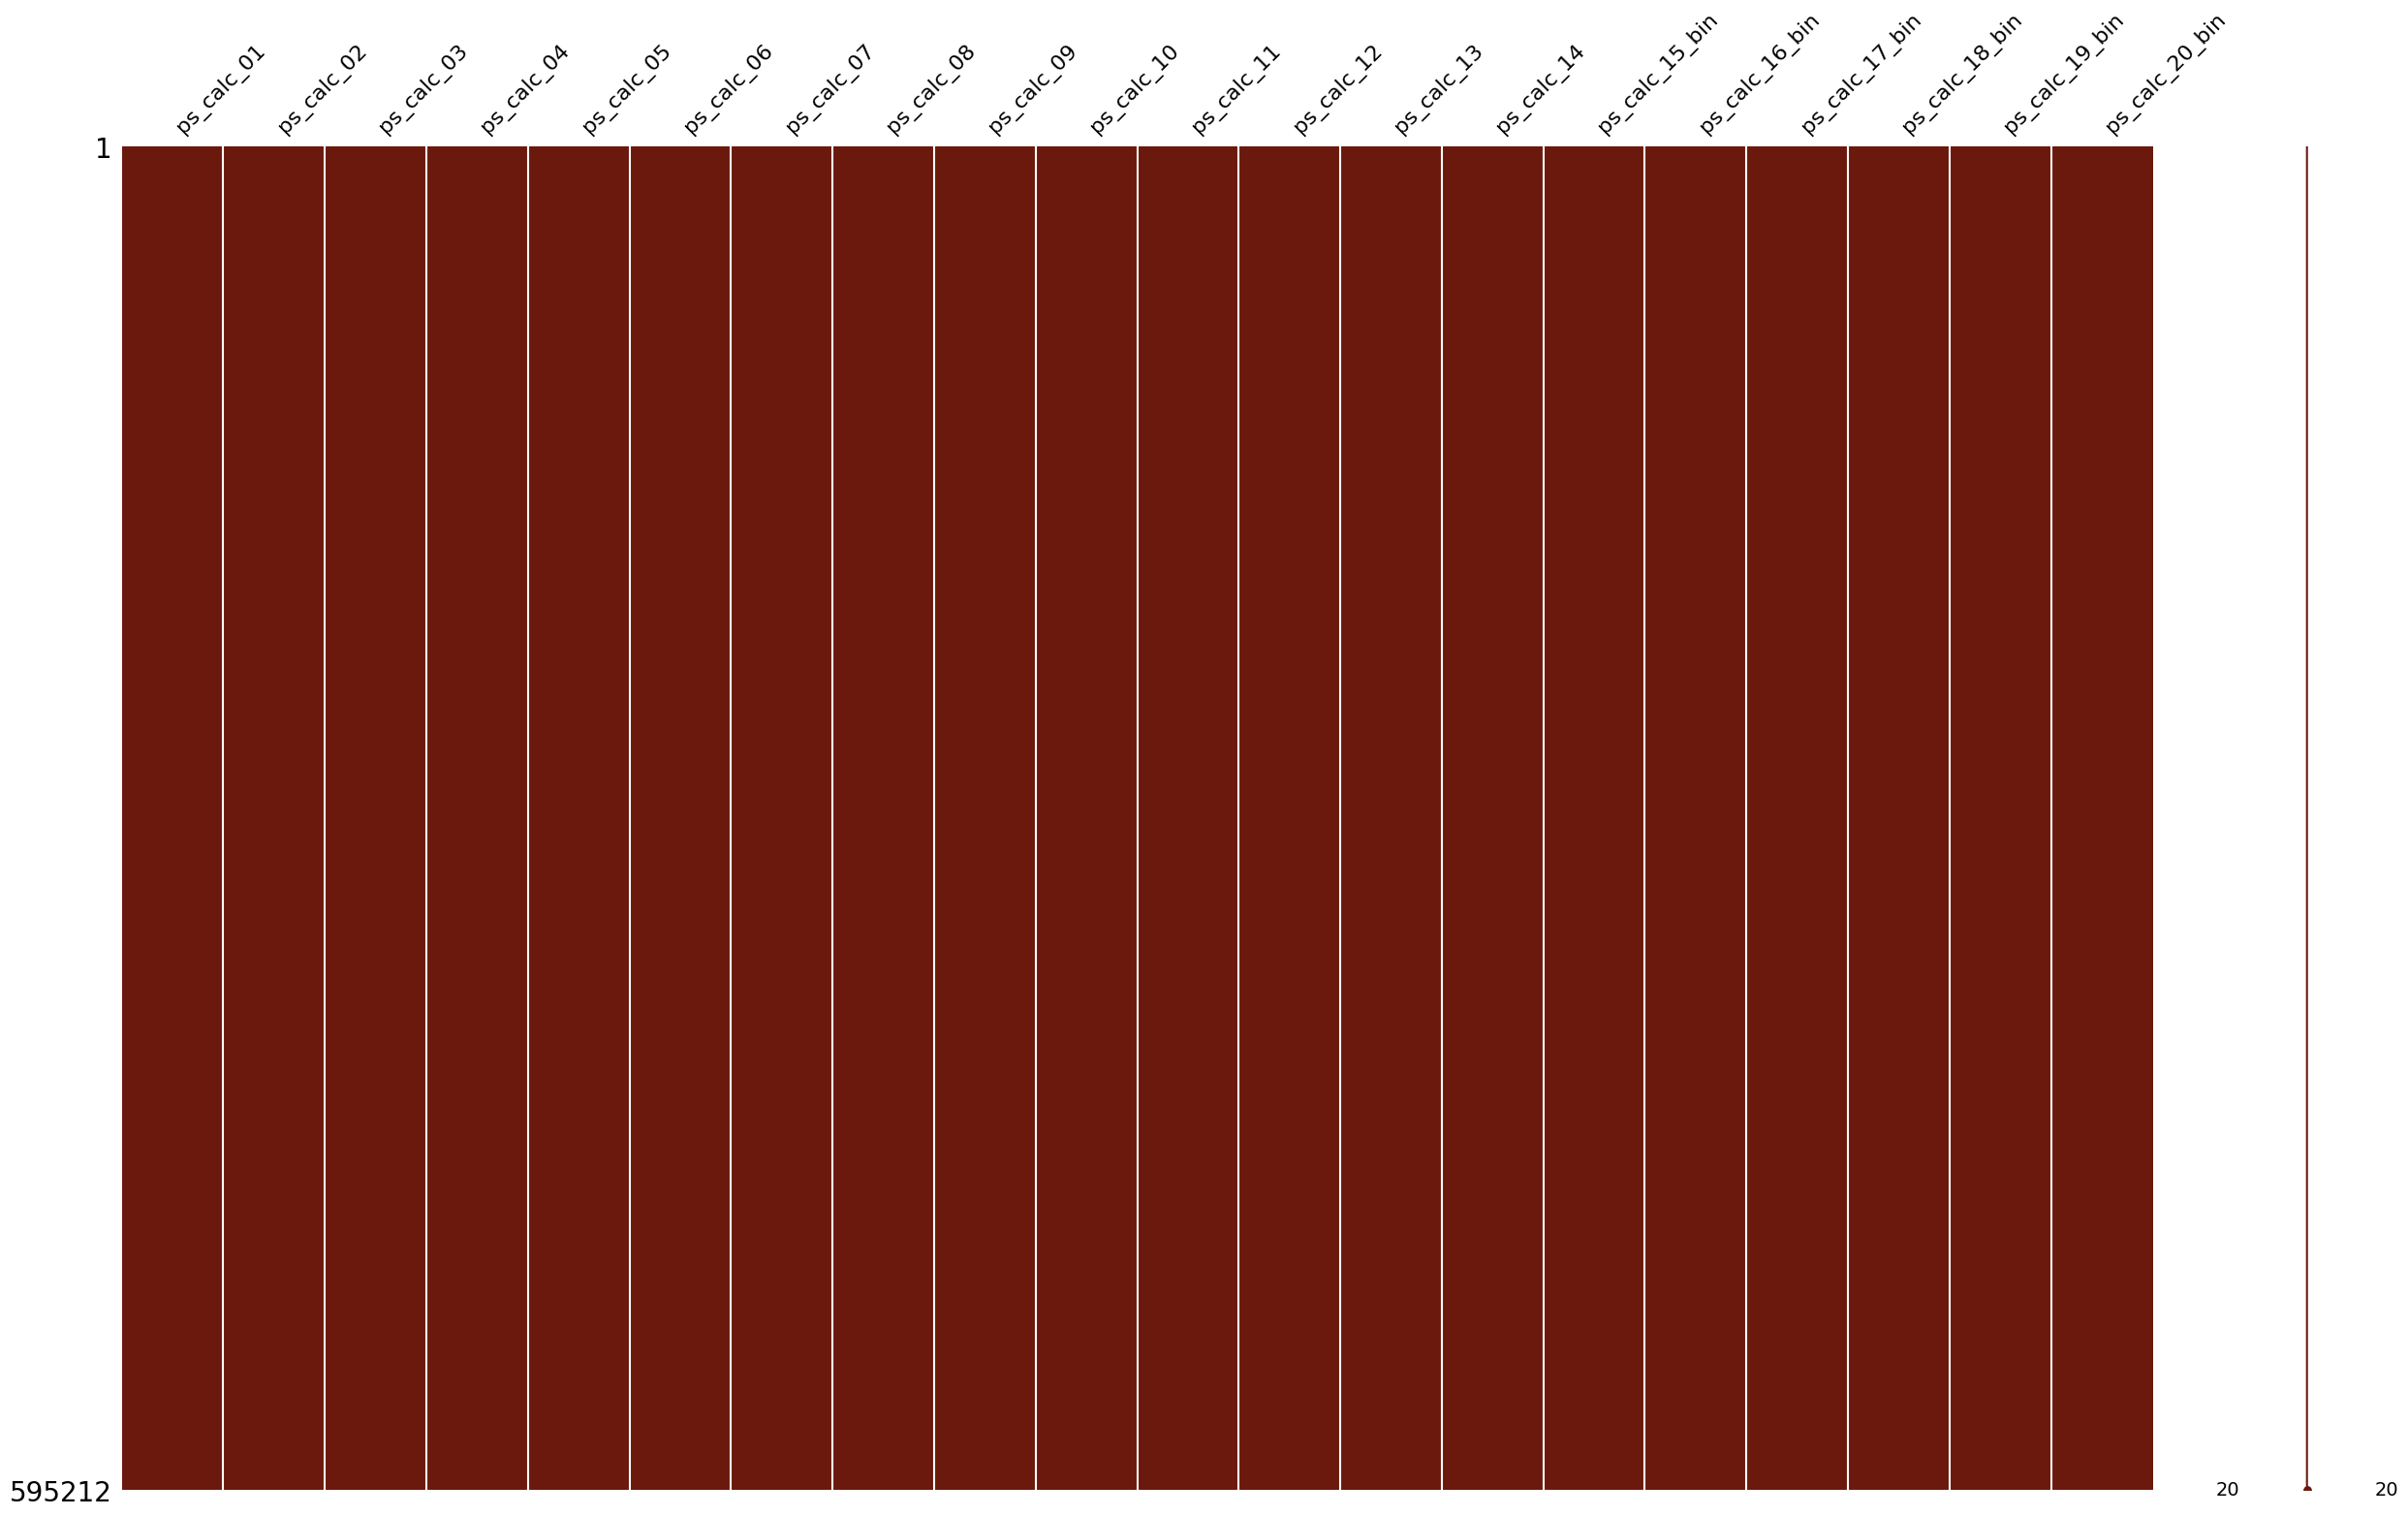

In [13]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:, 39:], figsize=(30, 18), color=(0.42, 0.1, 0.05))
plt.show()

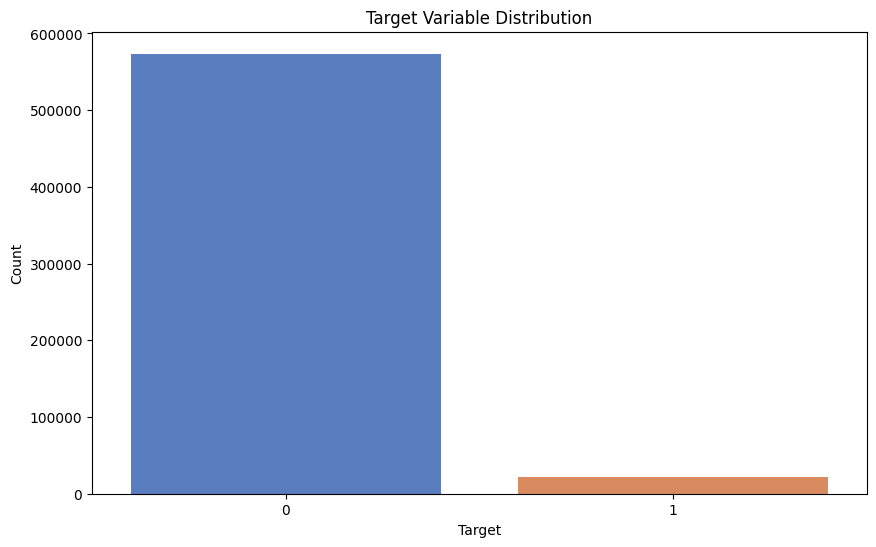

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the counts of unique values in the 'target' column
target_counts = train['target'].value_counts()

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x=target_counts.index, y=target_counts.values, palette='muted')

# Add titles and labels
plt.title('Target Variable Distribution')
plt.xlabel('Target')
plt.ylabel('Count')

# Display the plot
plt.show()

In [15]:
train['target'].value_counts() / train.shape[0]

target
0    0.963552
1    0.036448
Name: count, dtype: float64

target variable is imbalanced

### Datatype Check

In [16]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [17]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

trying to look at float datatype (continuous features) and integer datatype (binary, categorical, and ordinal features)

### Correlation plots

#### 1. Correlation of float features

<Axes: title={'center': 'Pearson Correlation of Continuous Features'}>

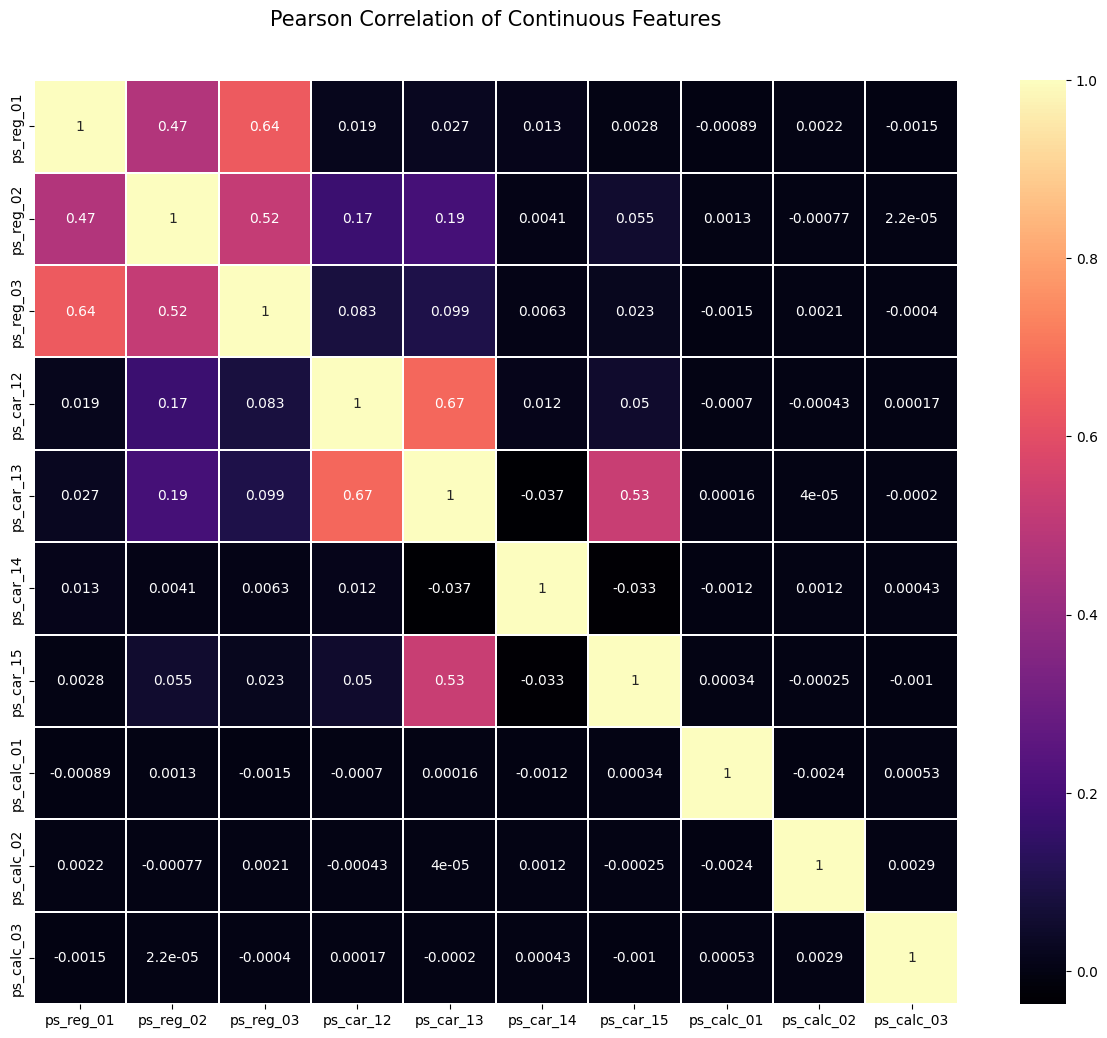

In [18]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title('Pearson Correlation of Continuous Features', y=1.05, size=15)
sns.heatmap(
    train_float.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    cmap=colormap,
    linecolor='white',
    annot=True
)

From correlation plot, we can see that the majority of features display 0 or no correlation to one another. This is quite an interesting observation that will warrant our further investigation later down. For now, the paired features that display a positive linear correlation are listed as follows:
- (ps_reg_01, ps_reg_03)
- (ps_reg_02, ps_reg_03)
- (ps_car_12, ps_car_13)
- (ps_car_13, ps_car_15)

#### 2. Correlation of integer features

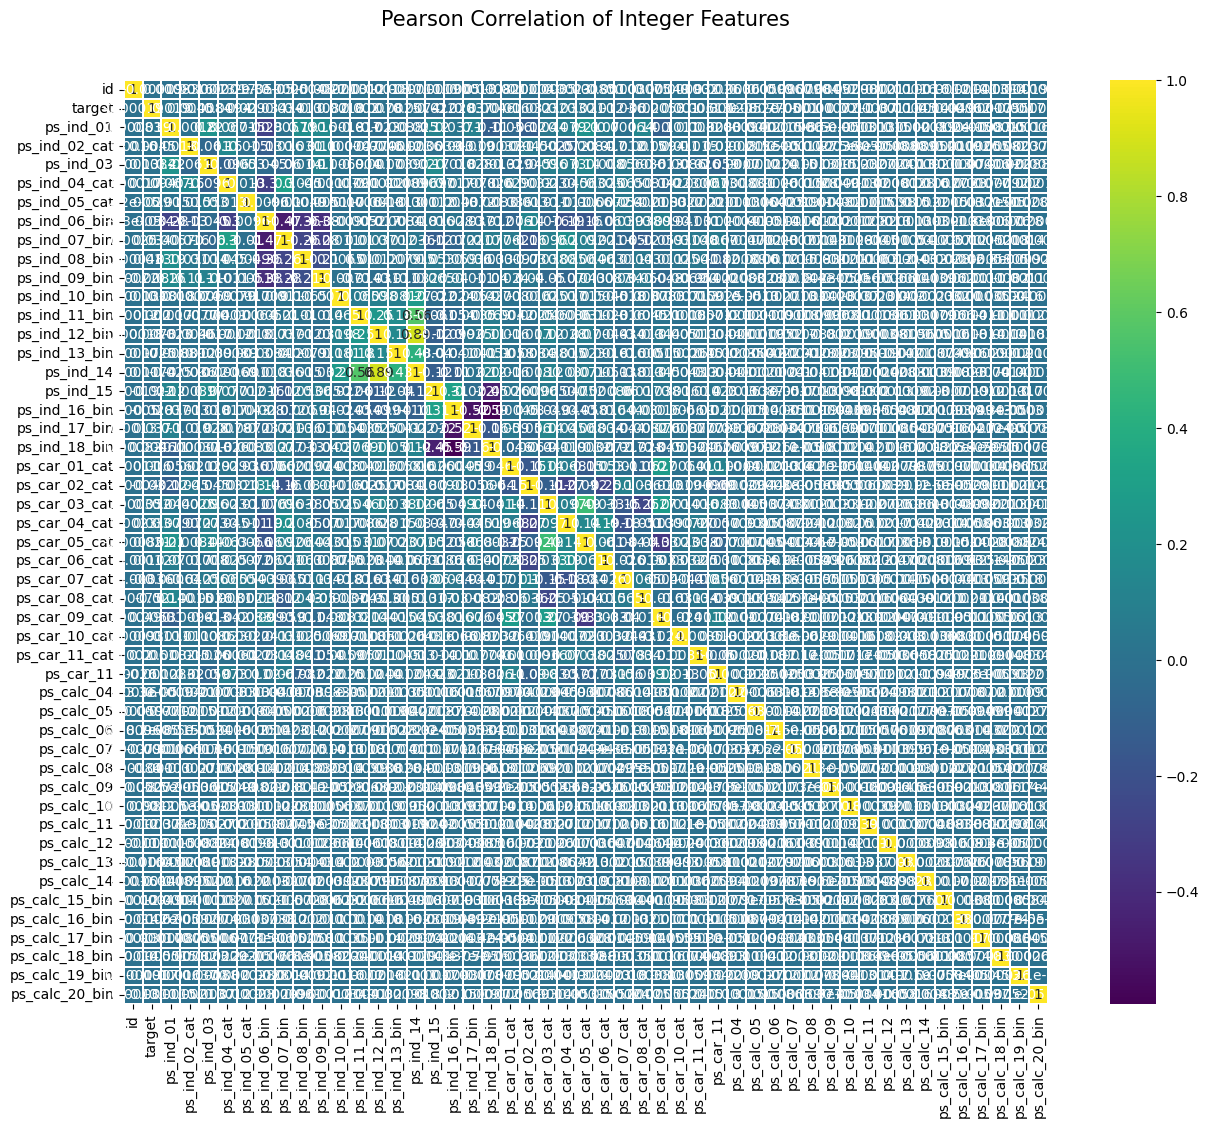

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_int is a DataFrame with integer features
# Calculate the correlation matrix
corr_matrix = train_int.astype(float).corr()

# Set the figure size
plt.figure(figsize=(16, 12))

# Create the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,                  # Annotate cells with the correlation values
    cmap='viridis',              # Use the 'viridis' colormap
    cbar=True,                   # Show the color bar
    square=True,                 # Make each cell square
    linewidths=0.1,              # Width of the lines that will divide each cell
    linecolor='white'            # Color of the lines that will divide each cell
)

# Add the title
plt.title('Pearson Correlation of Integer Features', size=15, y=1.05)

# Show the plot
plt.show()

We can observe that there's a huge number of columns that are not linearly correlated with each other at all, evident from the fact that we observe quite a lot of 0 value cells in our correlation plot. This is quite a useful observation to us, especially if we are trying to perform dimensionality reduction transformations such as Principal Component Analysis (PCA), this would require a certain degree of correlation. We can note some features of interest are as follows:

- Negatively correlated features: ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

One interesting aspect to note is that in our earlier analysis on nullity, ps_car_03_cat and ps_car_05_cat were found to contain many missing or null values. Therefore, it should come as no surprise that both these features show quite a strong positive linear correlation to each other on this basis, albeit one that may not really reflect the underlying truth for the data.

### Mutual Information plots

Mutual information is another useful tool as it allows to inspect the mutual information between the target variable and the corresponding feature it is calculated against. This will therefore help give us of how much information from the target may be contained within the features.

In [20]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)

In [21]:
print(mf)

[0.02599971 0.00767074 0.00617141 0.01855302 0.00158483 0.00338192
 0.01668813 0.0134428  0.01334669 0.01348572]


### Binary features inspection

Another aspect of the data we may want to inspect would be the columns that only contain binary values, i.e. where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical barplot of these binary values as follows:

In [22]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col] == 0).sum())
    one_list.append((train[col] == 1).sum())

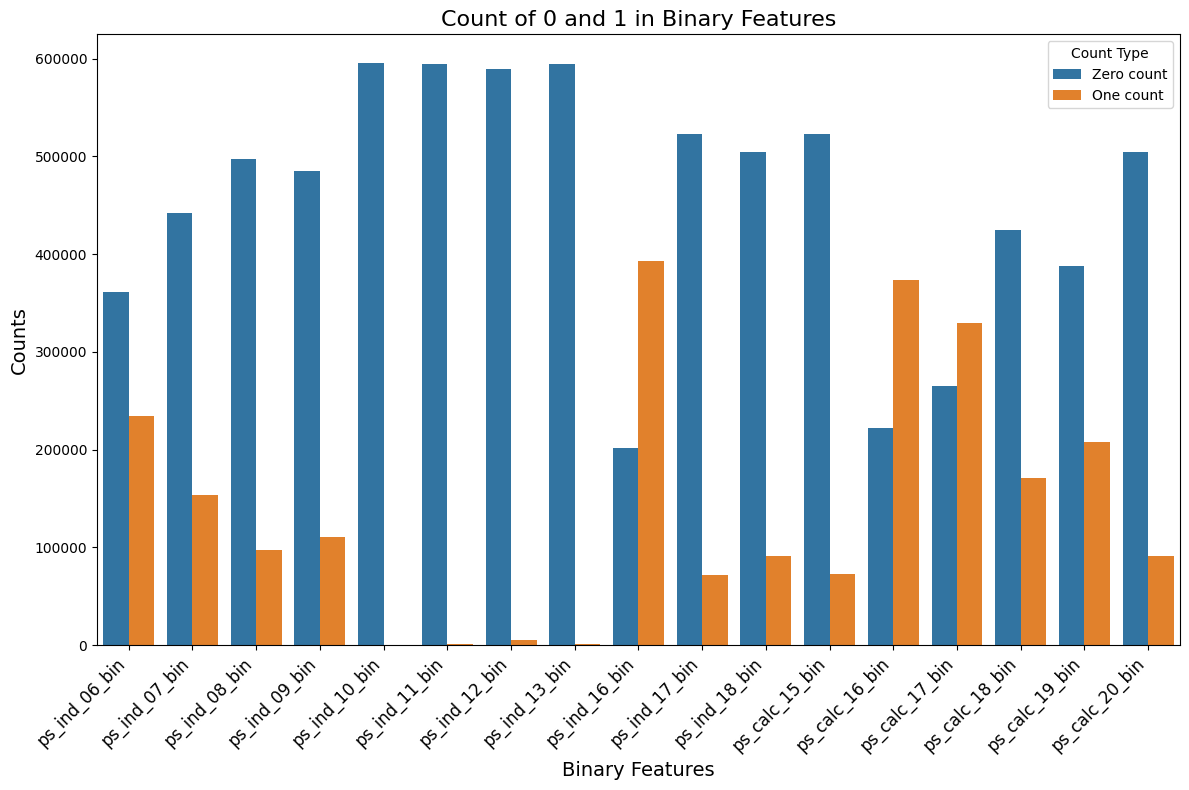

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data into a pandas DataFrame
data = {
    'Feature': bin_col,
    'Zero count': zero_list,
    'One count': one_list
}
df = pd.DataFrame(data)

# Melt the DataFrame to long format for seaborn compatibility
df_melted = pd.melt(df, id_vars='Feature', value_vars=['Zero count', 'One count'],
                    var_name='Count Type', value_name='Count')

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Feature', y='Count', hue='Count Type', data=df_melted)

# Add titles and labels
plt.title('Count of 0 and 1 in Binary Features', fontsize=16)
plt.xlabel('Binary Features', fontsize=14)
plt.ylabel('Counts', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Here we observe that there are 4 features: ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by 0s. This raises the question of whether these features are useful at all as they do not contain much information about the other classes.

### Categorical and Ordinal feature inspection

First take a look at the features that are termed categorical as per their suffix "_cat"

#### Feature importance via Random Forest


Let me now implement a Random Forest model where we fit the training data with a Random Forest Classifier and look at the ranking  of the features after the model has finished training. This is a quick way  of using ensemble  model (ensemble of weak decision tree learners applied under Bootstrap aggregated) which does not require much parameter tuning in obtaining useful feature importances and is also pretty robust to target imbalances.

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
    min_samples_leaf=4,
    max_features=0.2,
    n_jobs=-1,
    random_state=17
)

rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


#### Scatter Plot of feature importances

Having trained Random Forest, we can obtain a list of feature importances by invoking the attribute "feature_importances_" and plot our next Scatter plot.

The one thing we pay attention to in scatter plots is the marker attribute. It is the marker attribute where we define and hence control the size, color and scale of the scatter points embedded.

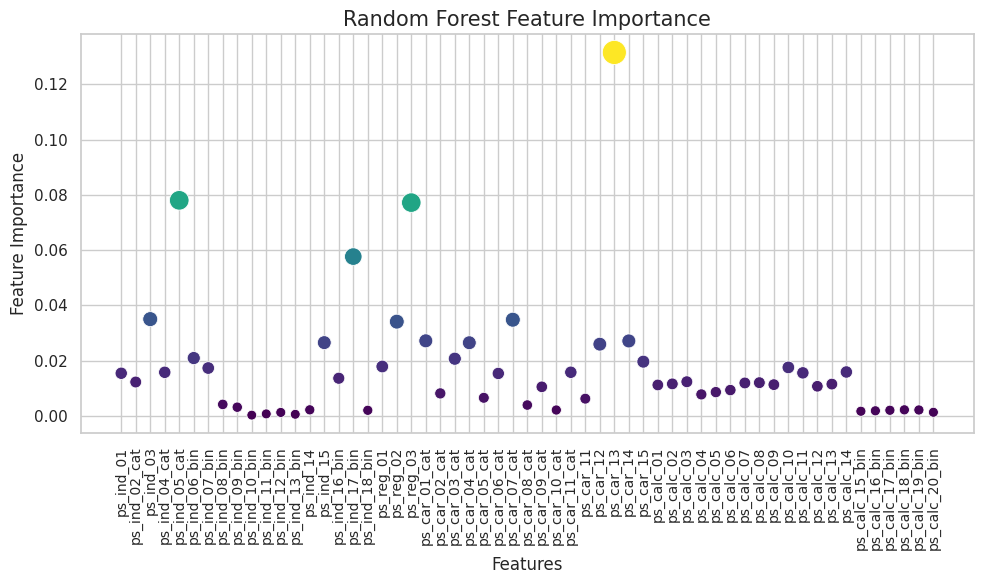

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'rf' is the trained RandomForestClassifier and 'features' are the feature names
feature_importances = rf.feature_importances_

# Create a DataFrame for better handling with seaborn
df_features = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Create a scatter plot using seaborn
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='Feature',
    y='Importance',
    hue='Importance',    # Color by feature importance
    size='Importance',   # Size by feature importance
    sizes=(50, 300),     # Define the min and max size of the points
    data=df_features,
    palette='viridis',
    legend=False         # Hide the legend
)

# Customize the plot
plt.title('Random Forest Feature Importance', fontsize=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

Furthermore, we can also display a sorted list of all the features ranked by order of their importance, from highest to lowest via same barplots as follows:

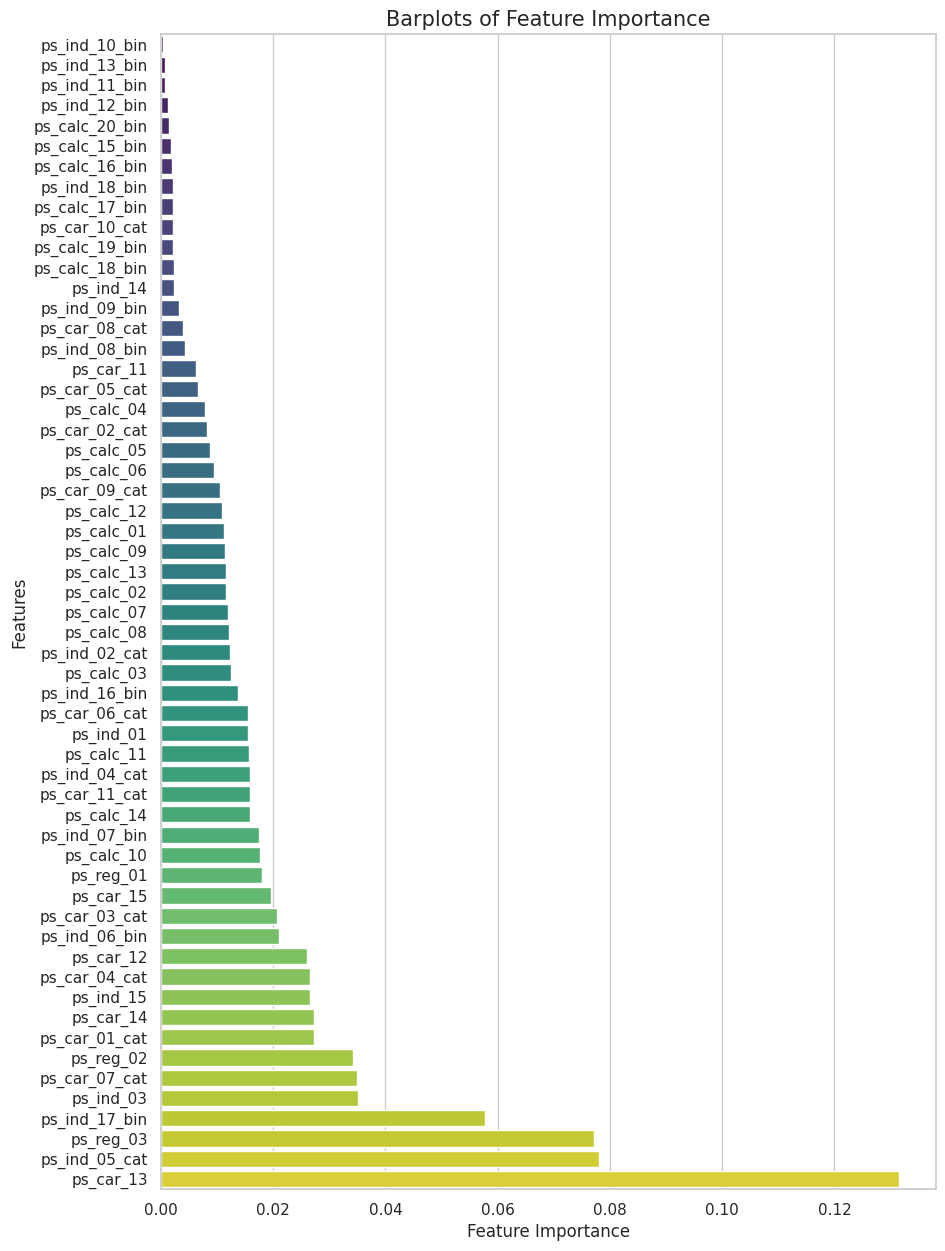

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'rf' is the trained RandomForestClassifier and 'features' are the feature names
feature_importances = rf.feature_importances_

# Sort the features by importance
sorted_idx = np.argsort(feature_importances)
sorted_importances = feature_importances[sorted_idx]
sorted_features = features[sorted_idx]

# Create a DataFrame for easier plotting with seaborn
df_importance = pd.DataFrame({
    'Feature': sorted_features,
    'Importance': sorted_importances
})

# Set the style
sns.set(style='whitegrid')

# Create the bar plot using seaborn
plt.figure(figsize=(10, 15))
colors = sns.color_palette("viridis", len(sorted_features))
barplot = sns.barplot(
    x='Importance',
    y='Feature',
    data=df_importance,
    palette=colors
)

# Add titles and labels
plt.title('Barplots of Feature Importance', fontsize=15)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Show the plot
plt.show()

#### Decision Tree Visualization

One other interesting trick or technique often used would be to visualize the tree branches or decisions made by the model. For simplicity, I fit a decision tree (of max_depth = 3) and hence you only see 3 levels in the decision branch, use the export to graph visualization attribute sklearn "export_graphviz" and then export and import the tree image for visualization in this notebook.

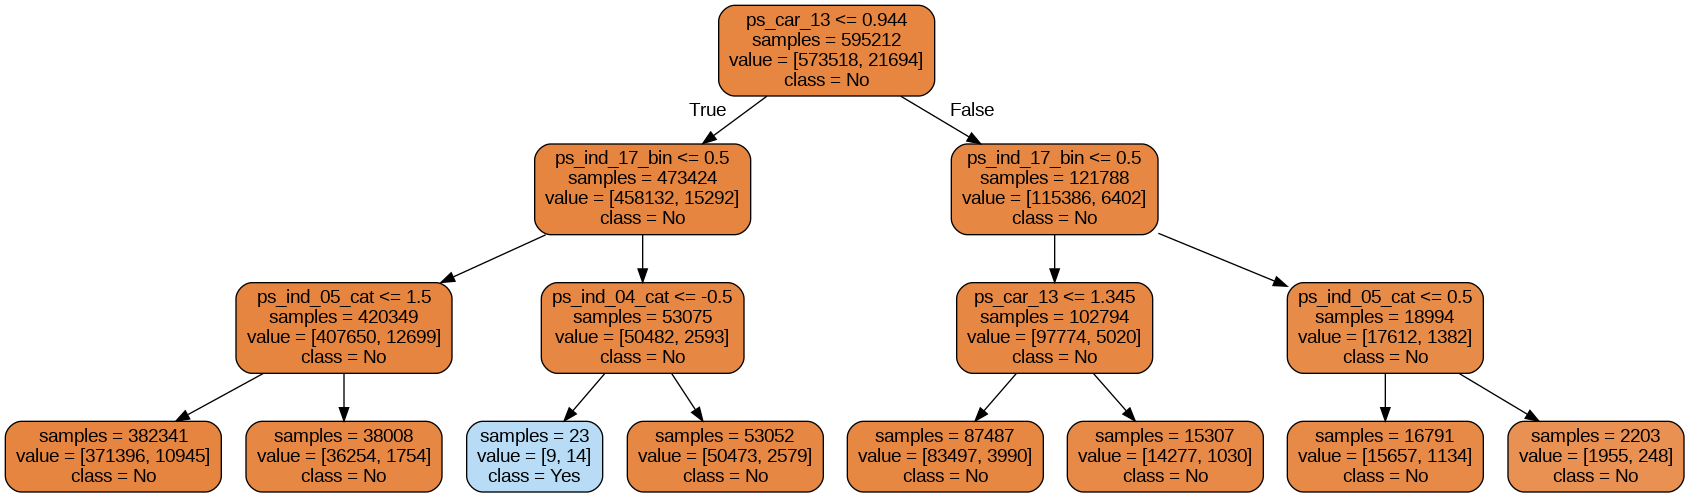

In [27]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id', 'target'], axis=1), train.target)

# Export our train model as a .dot file
with open(r'tree1.dot', 'w') as f:
    f = tree.export_graphviz(
        decision_tree,
        out_file=f,
        max_depth=4,
        impurity=False,
        feature_names=train.drop(['id', 'target'], axis=1).columns.values,
        class_names=['No', 'Yes'],
        rounded=True,
        filled=True
)

# Convert .dot to .png to allow display in web notebook
check_call(['dot', '-Tpng', r'tree1.dot', '-o', r'tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save(r'sample-out.png')
PImage(r'sample-out.png')

#### Feature importance via Gradient Boosting model

Just for curiosity, let me try another learning method in getting our feature importances. This time, we use a Gradient Boosting classifier to fit to the training data. Gradient Boosting proceeds in a forward stage-wise fashion, where at each stage regression trees are fitted on the gradient of the loss function (which defaults to the deviance in Sklearn implementation).

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    n_estimators=150,
    max_depth=8,
    min_samples_leaf=4,
    max_features=0.2,
    random_state=17
)

gb.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


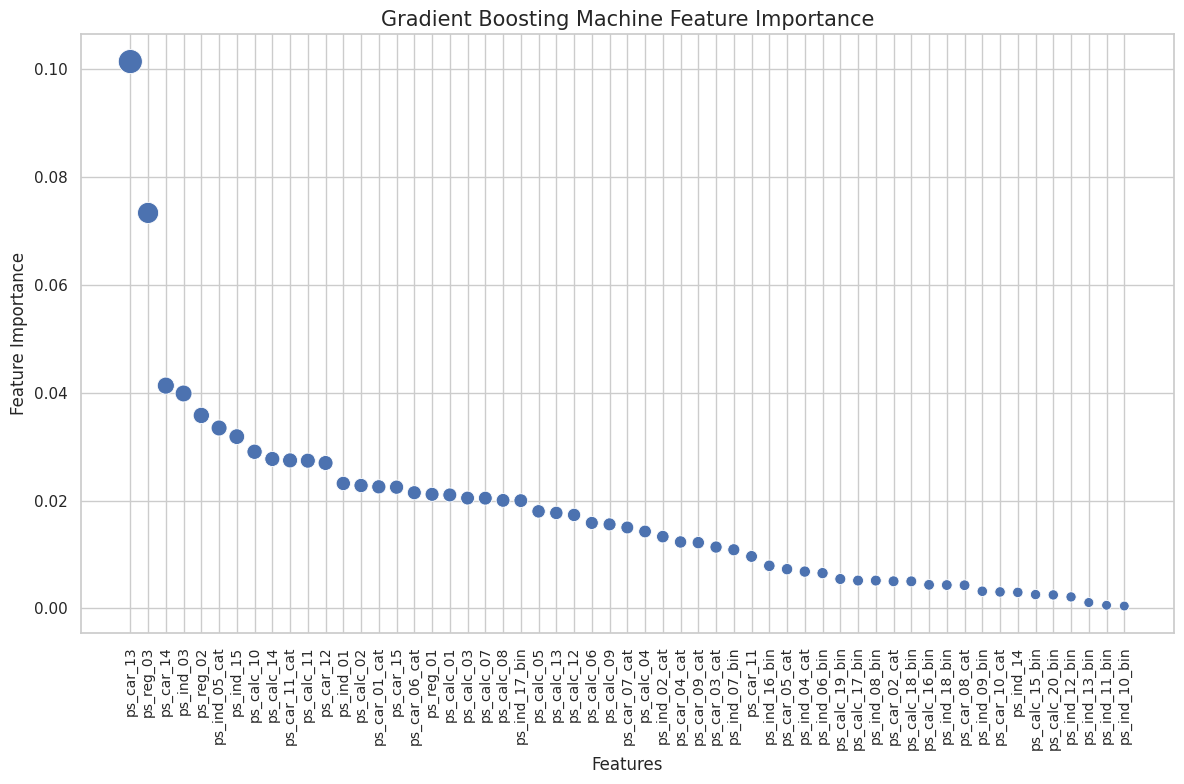

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'gb' is the trained GradientBoostingClassifier and 'features' are the feature names
feature_importances = gb.feature_importances_

# Create a DataFrame for better handling with seaborn
df_features = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the features by importance for better visualization
df_features = df_features.sort_values(by='Importance', ascending=False)

# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Create the scatter plot using seaborn
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='Feature',
    y='Importance',
    size='Importance',   # Size by feature importance
    sizes=(50, 300),     # Define the min and max size of the points
    data=df_features,
    palette='viridis',
    legend=False         # Hide the legend
)

# Customize the plot
plt.title('Gradient Boosting Machine Feature Importance', fontsize=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

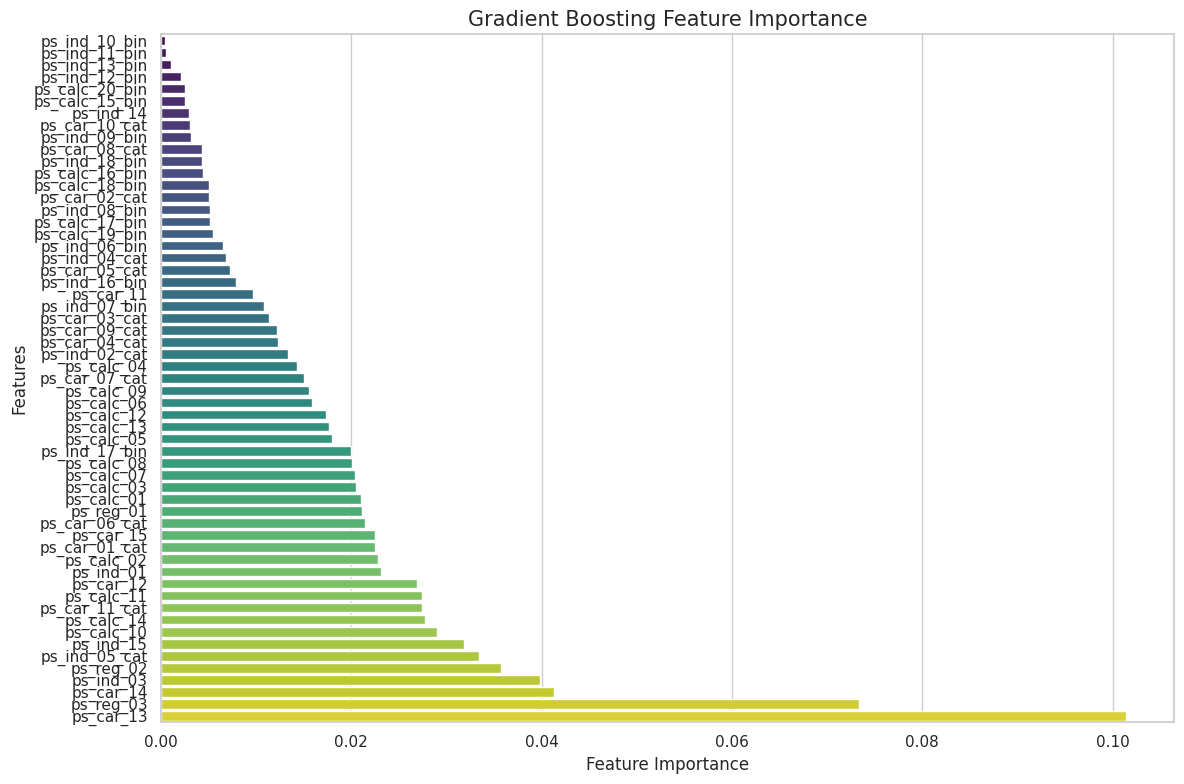

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'gb' is the trained GradientBoostingClassifier and 'features' are the feature names
feature_importances = gb.feature_importances_

# Sort the features by importance for better visualization
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(features)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Create a DataFrame for easier handling with seaborn
df_importance = pd.DataFrame({
    'Feature': sorted_features,
    'Importance': sorted_importances
})

# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Create the horizontal bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=df_importance,
    palette='viridis'  # Use a colormap similar to 'Viridis'
)

# Customize the plot
plt.title('Gradient Boosting Feature Importance', fontsize=15)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

Interestingly, we observe that in both Random Forest and Gradient Boosting learning models, the most important feature that both models picked out was the column: pc_car_13.

### Dimensionality Reduction (PCA, tSNE)

In [31]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    import matplotlib.cm as cm
    import seaborn as sns
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

In [32]:
target_names = np.unique(train['target'].values)
print('There are %d unique target values in this dataset:' % (len(target_names)), target_names)

There are 2 unique target values in this dataset: [0 1]


Principal Component Analysis (PCA) identifies the combination of components (directions in the feature space) that account for the most variance of the data.

In [33]:
print('\nLoading data...\n')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X = train.drop(['id', 'target'], axis=1).values
y = train['target'].values.astype(np.int8)


Loading data...



In [34]:
n_comp = 20
# PCA
print("\nRunning PCA...")
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X)
print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())

print("Individual variance contributions:")
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])


Running PCA...
Explained variance: 0.9944
Individual variance contributions:
0.9077327018849175
0.025423406321501703
0.011033728952072604
0.007026875356199512
0.006283416003140611
0.006119747729235822
0.005358647266808211
0.004532740198131301
0.0036293073197562345
0.0029426228826479666
0.0023924601214410472
0.001774643302319551
0.0016665349075175712
0.0015118573722780124
0.0014828537818274451
0.0012950139999157138
0.0012052148134726172
0.00107276310619847
0.001039529063489953
0.0008415527677793349


Better than 90% of the data is explained by a single principal component. Just a shade under 99% of variance is explained by 15 components, which means that this dataset can be safely reduced to ~ 15 features.
Here I plot 0/1 samples on the first 2 PC.

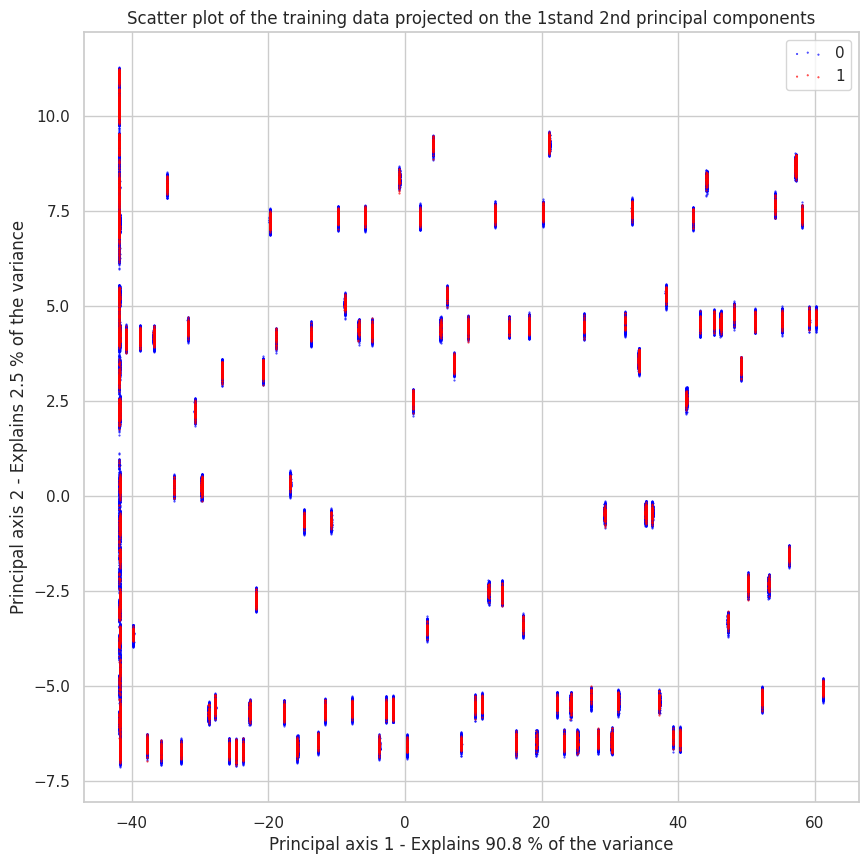

In [35]:
colors = ['blue', 'red']
plt.figure(figsize=(10, 10))

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, s=1, alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
  "Scatter plot of the training data projected on the 1st"
  "and 2nd principal components"
)
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (pca.explained_variance_ratio_[1] * 100.0))
plt.savefig('pca-porto-01.png', dpi=150)
plt.show()

There is a nice separation between various groups of customers, but not so between 0/1 categories within each group. This is somewhat exaggerated by the fact that "0" points (blue) are plotted first and "1" points (red) are plotted last. There seems to be more red than blue in the image, even though there are >25x "0" points in reality. I'd be grateful if someone knows how to plot this in a way that would not create this misleading impression.

Regardless, 0/1 points are not separated well at all. That means they will not be easy to classify, which we all know by now.

Let's encode the categorical variables and try again.